In [3]:
import json
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

def load_data(path) -> Sequence[TimeStepStats]:
    with open(path, "r") as f:
        payload = json.load(f)
    return [TimeStepStats.from_json(x) for x in payload]

dataset = {
    # 'baseline': load_data("../stats/fpm_0_sticking.json"),
    # '1': load_data("../stats/fpm_0_sticking_solver_1.json"),

    # 'baseline': load_data("../stats/fpm_0_open.json"),
    # '1': load_data("../stats/fpm_0_open_solver_1.json"),

    # 'baseline': load_data("../stats/fpm_0_sliding.json"),
    '1': load_data("../stats/fpm_0_sliding_solver_1.json"),

    # 'baseline': load_data("../stats/fpm_2_sliding.json"),
    # '1': load_data("../stats/fpm_2_sliding_solver_1.json"),
}
data = dataset['baseline']

KeyError: 'baseline'

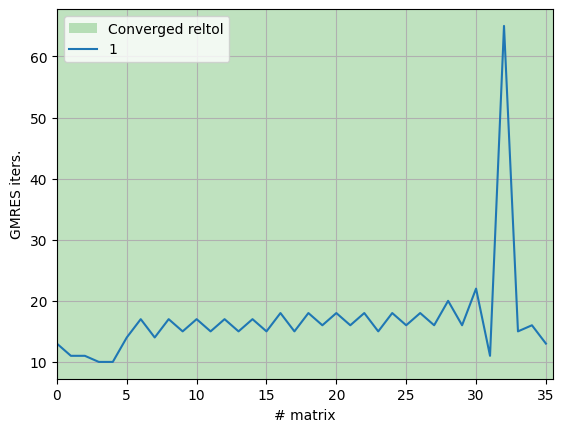

In [4]:
# %matplotlib ipympl
color_converged_reason(data)
for name, data in dataset.items():
    plt.plot(get_gmres_iterations(data), label=name)
    plt.ylabel('GMRES iters.')
    plt.xlabel('# matrix')
    # plt.yscale('log')
plt.legend()

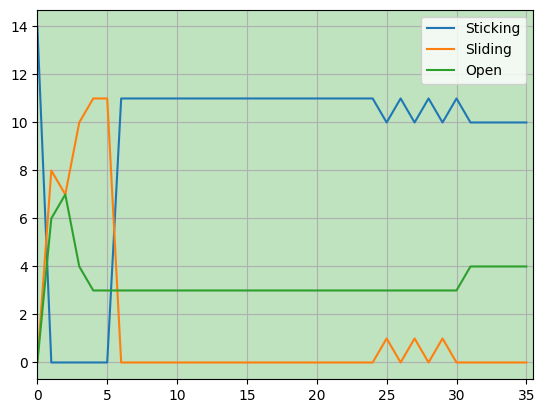

In [6]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
color_converged_reason(data, legend=False)
plt.plot(sticking, label='Sticking')
plt.plot(sliding, label='Sliding')
plt.plot(open_, label='Open')
plt.legend()

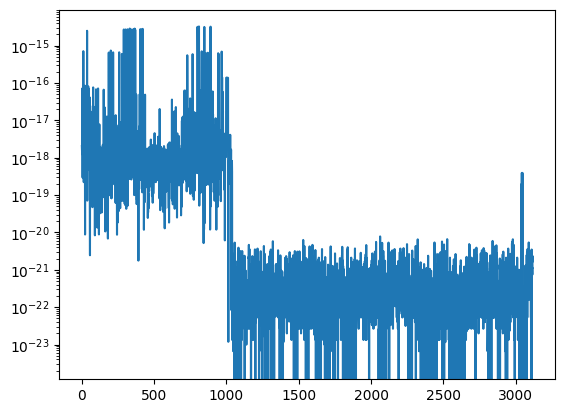

In [18]:
import scipy.sparse
from pathlib import Path
from stats import LinearSolveStats, TimeStepStats
from plot_utils import *


mat, rhs = load_matrix_rhs(data, 16)
# spy(mat)
plt.plot(abs(rhs))
plt.yscale('log')

In [19]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_0 import make_model
from pp_utils import make_block_mat

model = make_model()
model.prepare_simulation()

model.time_manager.increase_time()
model.time_manager.increase_time_index()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model.assemble_linear_system()

model._initialize_solver()
block_matrix = make_block_mat(model, mat)
eq_blocks = model.make_equations_groups()
var_blocks = model.make_variables_groups()

model.linear_system = mat, rhs

rhs_permuted = model.permutation @ rhs

reordered_mat, preconditioner = model._prepare_solver()

ImportError: cannot import name 'make_block_mat' from 'pp_utils' (/home/porepy/simulations/pp_utils.py)

Solve  took: 0.15


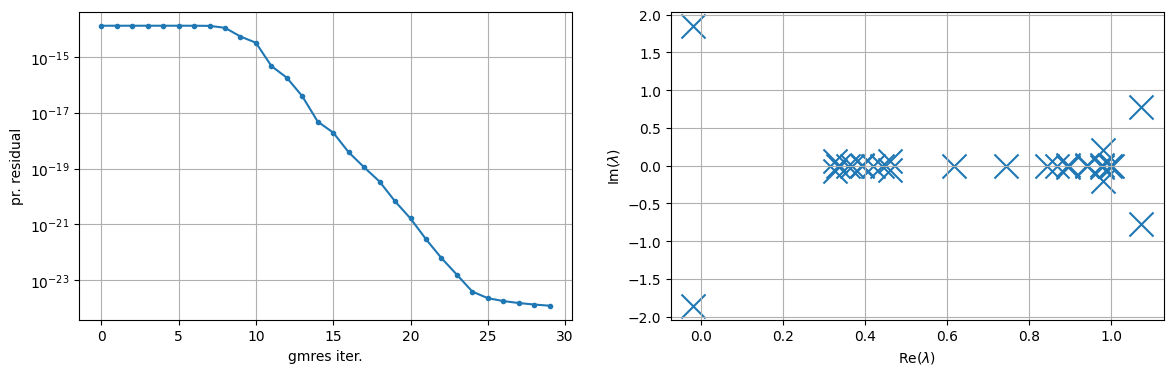

In [ ]:
solve_petsc(reordered_mat, preconditioner, rhs=rhs_permuted)

In [ ]:
Omega_amg = preconditioner.Omega_inv
rhs_omega = rhs_permuted[preconditioner.sep:]
Omega = bmat([
    [model.Bp, model.C2p],
    [model.C1p, model.Ap]
])
solve_petsc(Omega, Omega_amg, rhs=rhs_omega)

AttributeError: 'OmegaInv' object has no attribute 'Omega_inv'

Solve  took: 0.02


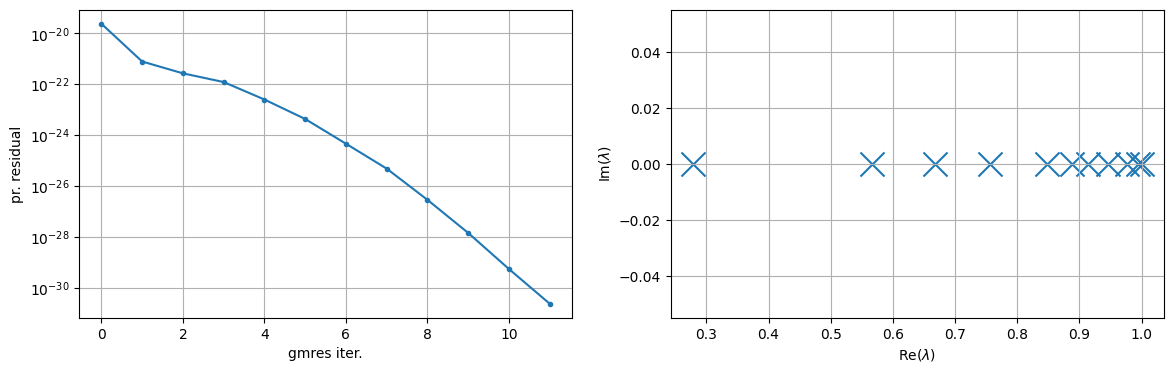

In [ ]:
B_amg = Omega_amg.B_inv
rhs_B = rhs_omega[:Omega_amg.sep]
B = B_amg.get_matrix()
solve_petsc(B, B_amg, rhs_B)

Solve  took: 0.0


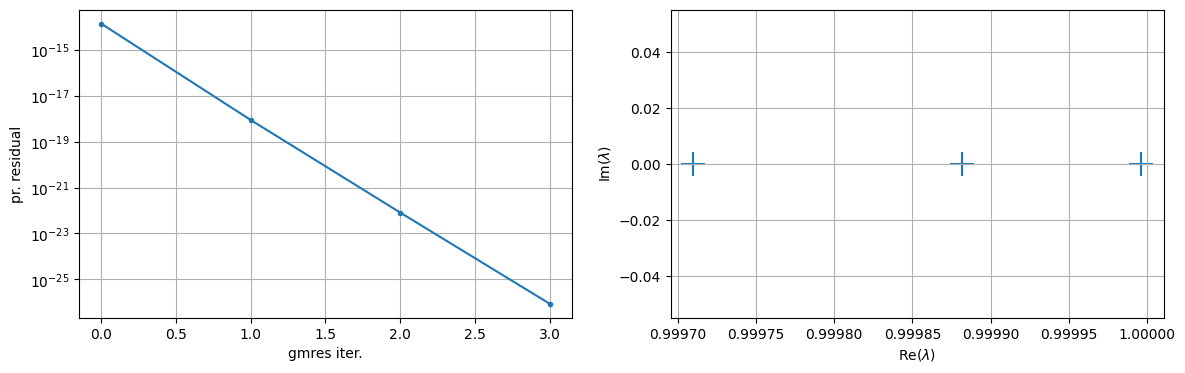

In [ ]:
S_A_amg = Omega_amg.S_A_inv
rhs_A = rhs_omega[Omega_amg.sep:]
S_A = S_A_amg.get_matrix()
solve_petsc(S_A, S_A_amg, rhs_A)

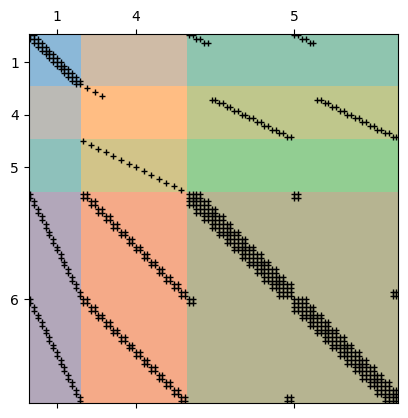

In [ ]:
from pp_utils import get_equations_group_ids, get_variables_group_ids


dim_max = model.mdg.dim_max()
sd_ambient = model.mdg.subdomains(dim=dim_max)
sd_lower = [k for i in reversed(range(0, dim_max)) for k in model.mdg.subdomains(dim=i)]
sd_frac = model.mdg.subdomains(dim=dim_max - 1)
intf = model.mdg.interfaces()
intf_frac = model.mdg.interfaces(dim=dim_max - 1)

var_idx = get_variables_group_ids(
    variable_to_idx=make_variable_to_idx(model),
    md_variables_groups=[
        [model.pressure(sd_ambient)],
        [model.displacement(sd_ambient)],
        [model.pressure(sd_lower)],
        [model.interface_darcy_flux(intf)],
        [model.contact_traction(sd_frac)],
        [model.interface_displacement(intf_frac)],
    ],
)

eq_idx = get_equations_group_ids(
    equation_to_idx=make_equation_to_idx(model),
    equations_group_order=[
        [("mass_balance_equation", sd_ambient)],  # 0
        [("momentum_balance_equation", sd_ambient)],  # 1
        [("mass_balance_equation", sd_lower)],  # 2
        [("interface_darcy_flux_equation", intf)],  # 3
        [
            ("normal_fracture_deformation_equation", sd_lower),  # 4
            ("tangential_fracture_deformation_equation", sd_lower),
        ],
        [("interface_force_balance_equation", intf)],  # 5
    ],
)

# diagnostics = model.run_diagnostics(grouping='dense')
# model.plot_diagnostics(diagnostics, key='max')
# plot_mat(concatenate_blocks(block_matrix, eq_idx[3], var_idx[3]))
color_spy(
    block_matrix,
    eq_idx[2] + eq_idx[4] + eq_idx[5],
    var_idx[2] + var_idx[4] + var_idx[5],
); plt.show()
x = concatenate_blocks(
    block_matrix,
    eq_idx[2] + eq_idx[4] + eq_idx[5],
    var_idx[2] + var_idx[4] + var_idx[5],
)
# plot_eigs(x)

In [ ]:
cond(x)

4256557760307.435

170.2695942656701


/home/porepy/simulations/plot_utils.py:88: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


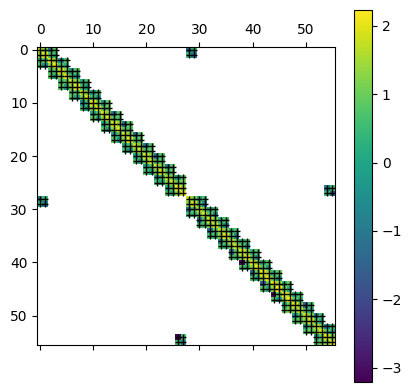

In [ ]:
x = concatenate_blocks(
    block_matrix,
    eq_idx[5],
    # var_idx[3],
    var_idx[5],
    # var_idx[0] + var_idx[1],
)
print(abs(x).max())

plot_mat(x, log=True)
spy(x)

In [ ]:
x.data.max()

69033923182.15164

In [ ]:
intf = model.mdg.interfaces(dim=1)
model.interface_darcy_flux_equation(intf)

Operator 'interface_darcy_flux_equation' formed by Operations.sub with 2 children.

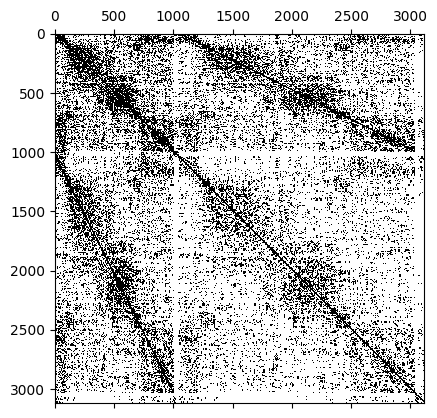

In [ ]:
spy(mat)

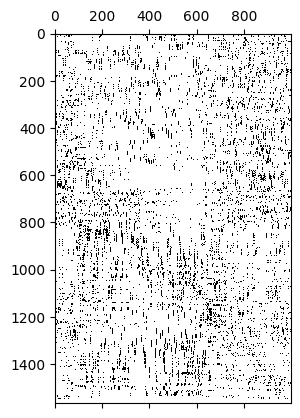

In [ ]:
sd = model.mdg.subdomains()
spy(model.pressure_trace(sd).value_and_jacobian(model.equation_system).jac[:, :1000])

In [ ]:
subdomains = model.mdg.subdomains()
interfaces: list[pp.MortarGrid] = model.subdomains_to_interfaces(subdomains, [1])
projection = pp.ad.MortarProjections(model.mdg, subdomains, interfaces, dim=1)
discr = model.darcy_flux_discretization(subdomains)
p = model.pressure(subdomains)

boundary_operator = model._combine_boundary_operators(  # type: ignore[call-arg]
    subdomains=subdomains,
    dirichlet_operator=model.pressure,
    neumann_operator=model.darcy_flux,
    bc_type=model.bc_type_darcy_flux,
    name="bc_values_darcy",
)

res = discr.bound_pressure_face @ (
    projection.mortar_to_primary_int @ model.interface_darcy_flux(interfaces)
)

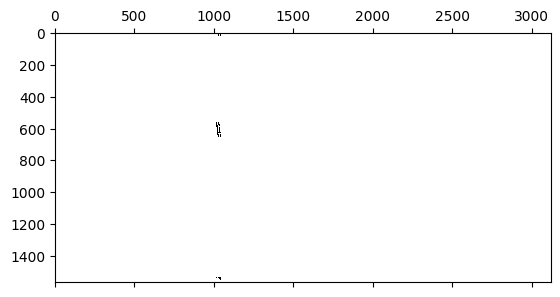

In [ ]:
spy(res.value_and_jacobian(model.equation_system).jac)

In [ ]:
# data = res.value_and_jacobian(model.equation_system).jac.data
# abs(data).min()

In [ ]:
model.discretize()